In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
# install findspark using pip
!pip install -q findspark

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import matplotlib.pyplot as plt

## Part I

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Medical_info.csv to Medical_info.csv


In [ ]:
meddf = spark.read.csv('Medical_info.csv',inferSchema=True, header =True,nanValue=" ")
meddf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- PSA: double (nullable = true)
 |-- TG: integer (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- LDLChole: integer (nullable = true)
 |-- HDLChole: integer (nullable = true)
 |-- Glucose: double (nullable = true)
 |-- Testosterone: double (nullable = true)
 |-- BP_1: integer (nullable = true)



In [ ]:
meddf.show(n=10)

+--------+---+------+----+---+-----------+--------+--------+-------+------------+----+
|      id|age|   BMI| PSA| TG|Cholesterol|LDLChole|HDLChole|Glucose|Testosterone|BP_1|
+--------+---+------+----+---+-----------+--------+--------+-------+------------+----+
|19782173| 59|28.378|0.34|204|      196.0|     132|      49|   92.0|         7.7|   1|
|32613511| 59|24.968| 1.0|147|      181.0|     129|      34|   96.0|        4.09|   1|
|32723850| 48|31.307|0.62|155|      185.0|     127|      41|  139.0|         4.5|   1|
|22913531| 47|27.837|0.38|488|      254.0|     158|      55|  250.0|         5.3|   2|
|32628551| 55|22.662|0.49| 87|      175.0|     120|      44|   99.0|         6.9|   1|
|32678037| 68|23.985| 1.2| 96|      193.0|     135|      48|  125.0|         7.9|   2|
|11858247| 58|22.096|0.09| 70|      200.0|     133|      60|  154.0|         7.0|   2|
|32675456| 48|28.577|0.12|139|      151.0|      95|      37|  102.0|         5.6|   1|
|14681268| 63|25.034| NaN|243|      195.0| 

In [ ]:
meddfnew = meddf.na.drop()
print('Number of rows removed:', meddf.count() - meddfnew.count())

Number of rows removed: 58


*****Summary statistics of age*****
Min: 21.0000
Max: 90.0000
Mean: 53.3407
Median: 53.0000
Variance: 75.9114
Standard deviation: 8.7127


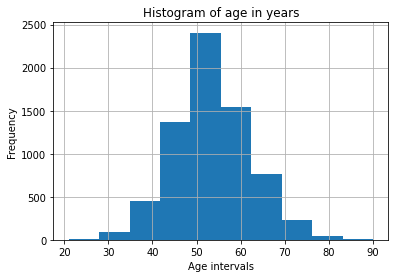

In [ ]:
print('*****Summary statistics of age*****')
print('Min: %.4f' %(meddfnew.toPandas()['age'].min()))
print('Max: %.4f' %(meddfnew.toPandas()['age'].max()))
print('Mean: %.4f' %(meddfnew.toPandas()['age'].mean()))
print('Median: %.4f' %(meddfnew.toPandas()['age'].median()))
print('Variance: %.4f' %(meddfnew.toPandas()['age'].var()))
print('Standard deviation: %.4f' %(meddfnew.toPandas()['age'].std()))
meddfnew.toPandas()['age'].plot.hist()
plt.xlabel('Age intervals')
plt.ylabel('Frequency')
plt.title('Histogram of age in years')
plt.grid()
plt.show()

******Quartile information of BMI******
First quartile: 22.975
Second quartile or median: 24.704
Third quartile: 26.435


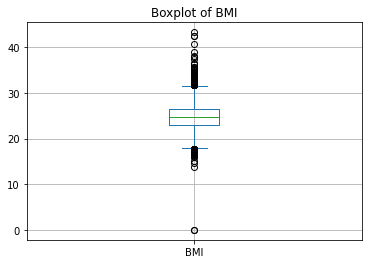

In [ ]:
print('******Quartile information of BMI******')
print('First quartile:', meddfnew.toPandas()['BMI'].quantile(q=0.25))
print('Second quartile or median:', meddfnew.toPandas()['BMI'].quantile(q=0.5))
print('Third quartile:', meddfnew.toPandas()['BMI'].quantile(q=0.75))
meddfnew.toPandas()['BMI'].plot.box()
plt.grid()
plt.title('Boxplot of BMI')
plt.show()

In [ ]:
print('Number of rows where age is greater than 50 and BP_1 equals 1:',meddfnew.filter("age > 50 and BP_1 =1").count())

Number of rows where age is greater than 50 and BP_1 equals 1: 2166


In [ ]:
from pyspark.ml.feature import StringIndexer,VectorAssembler
stages = []
cols = ['age','BMI','PSA','TG','Cholesterol','LDLChole','HDLChole','Glucose','Testosterone']
label_stringIdx = StringIndexer(inputCol = 'BP_1', outputCol = 'label')
stages += [label_stringIdx]
assembler = VectorAssembler(inputCols=cols, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
cols = meddfnew.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(meddfnew)
meddfnew = pipelineModel.transform(meddfnew)
selectedCols = ['label','features'] + cols
meddfnew = meddfnew.select(selectedCols)
meddfnew.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- PSA: double (nullable = true)
 |-- TG: integer (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- LDLChole: integer (nullable = true)
 |-- HDLChole: integer (nullable = true)
 |-- Glucose: double (nullable = true)
 |-- Testosterone: double (nullable = true)
 |-- BP_1: integer (nullable = true)



In [ ]:
train, test = meddfnew.randomSplit([0.7, 0.3], seed = 2020841)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 4815
Test Dataset Count: 2094


### Decision tree model fitting

In [ ]:
# Fitting decision tree model
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label',maxDepth=10)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'BMI', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+-------------+----------+--------------------+
|age|   BMI|label|rawPrediction|prediction|         probability|
+---+------+-----+-------------+----------+--------------------+
| 24|27.438|  0.0|    [2.0,0.0]|       0.0|           [1.0,0.0]|
| 27|25.087|  0.0|  [44.0,21.0]|       0.0|[0.67692307692307...|
| 28|21.551|  0.0|   [39.0,0.0]|       0.0|           [1.0,0.0]|
| 29|23.417|  0.0|   [37.0,0.0]|       0.0|           [1.0,0.0]|
| 30|22.434|  0.0|  [134.0,5.0]|       0.0|[0.96402877697841...|
| 30|23.301|  0.0|   [13.0,2.0]|       0.0|[0.86666666666666...|
| 30|24.604|  0.0|    [0.0,2.0]|       1.0|           [0.0,1.0]|
| 31|22.825|  0.0|   [37.0,0.0]|       0.0|           [1.0,0.0]|
| 31|22.862|  0.0|   [18.0,0.0]|       0.0|           [1.0,0.0]|
| 31|22.932|  0.0|   [39.0,0.0]|       0.0|           [1.0,0.0]|
+---+------+-----+-------------+----------+--------------------+
only showing top 10 rows



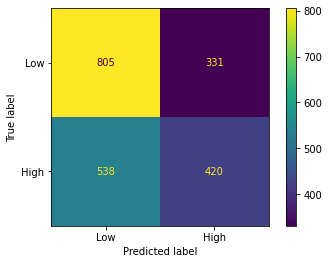

Test Area Under ROC: 0.5324376451821576
Accuracy score: 0.5850047755491882
F1 score: 0.5771982895601259
Precision: 0.5810357936183695
Recall: 0.5850047755491882


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(predictions.select(['label']).collect(),predictions.select(['prediction']).collect())
d = ConfusionMatrixDisplay(cm,display_labels=['Low','High'])
d.plot()
plt.show()
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
mceval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
print('Accuracy score:',mceval.evaluate(predictions))
mceval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
print('F1 score:',mceval.evaluate(predictions))
mceval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedPrecision')
print('Precision:',mceval.evaluate(predictions))

### Logistic regression model fitting

In [ ]:
from pyspark.ml.classification import LogisticRegression
logit = LogisticRegression(featuresCol = 'features', labelCol = 'label',maxIter=50)
logitModel = logit.fit(train)
predictions = logitModel.transform(test)
predictions.select('age', 'BMI', 'label', 'rawPrediction', 'prediction','probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   BMI|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|27.438|  0.0|[1.81504299240836...|       0.0|[0.85997026165881...|
| 27|25.087|  0.0|[2.05941157892255...|       0.0|[0.88689515758845...|
| 28|21.551|  0.0|[2.58111612824303...|       0.0|[0.92963631301961...|
| 29|23.417|  0.0|[2.27724146636339...|       0.0|[0.90697456584577...|
| 30|22.434|  0.0|[2.23731120034932...|       0.0|[0.90355039136578...|
| 30|23.301|  0.0|[2.54841905330313...|       0.0|[0.92746723341212...|
| 30|24.604|  0.0|[1.90825984856851...|       0.0|[0.87082352465252...|
| 31|22.825|  0.0|[2.07355161136159...|       0.0|[0.88830583355672...|
| 31|22.862|  0.0|[2.21238955625220...|       0.0|[0.90135659302198...|
| 31|22.932|  0.0|[2.28653970557648...|       0.0|[0.90775611100828...|
+---+------+-----+--------------------+----------+--------------

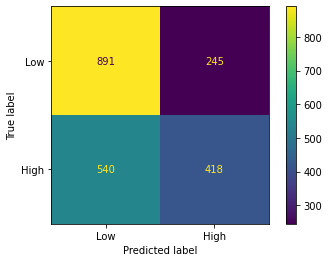

Test Area Under ROC: 0.6898835602340558
Accuracy score: 0.625119388729704
F1 score: 0.6125484632299268
Precision: 0.6262219142082014


In [ ]:
cm = confusion_matrix(predictions.select(['label']).collect(),predictions.select(['prediction']).collect())
d = ConfusionMatrixDisplay(cm,display_labels=['Low','High'])
d.plot()
plt.show()
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
mceval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
print('Accuracy score:',mceval.evaluate(predictions))
mceval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
print('F1 score:',mceval.evaluate(predictions))
mceval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedPrecision')
print('Precision:',mceval.evaluate(predictions))

## Part II

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Region_info.csv to Region_info.csv


In [ ]:
regdf = spark.read.csv('Region_info.csv',inferSchema=True, header =True)
regdf.printSchema()

root
 |-- population: double (nullable = true)
 |-- fertility: double (nullable = true)
 |-- HIV: double (nullable = true)
 |-- CO2: double (nullable = true)
 |-- BMI_male: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- BMI_female: double (nullable = true)
 |-- life: double (nullable = true)
 |-- child_mortality: double (nullable = true)
 |-- Region: string (nullable = true)



In [ ]:
regdfnew = regdf.drop('Region')
regdfnew.show()

+------------+---------+----+-------------------+------------------+-------+----------+----+---------------+
|  population|fertility| HIV|                CO2|          BMI_male|    GDP|BMI_female|life|child_mortality|
+------------+---------+----+-------------------+------------------+-------+----------+----+---------------+
| 3.4811059E7|     2.73| 0.1|  3.328944661018629|           24.5962|12314.0|  129.9049|75.3|           29.5|
| 1.9842251E7|     6.43| 2.0| 1.4743533878509398|          22.25083| 7103.0|  130.1247|58.3|          192.0|
|  4.038186E7|     2.24| 0.5|   4.78516998252535|           27.5017|14646.0|  118.8915|75.5|           15.4|
|   2975029.0|      1.4| 0.1|    1.8041062172001|          25.35542| 7383.0|  132.8108|72.5|           20.0|
| 2.1370348E7|     1.96| 0.1|   18.0163132681972|          27.56373|41312.0|  117.3755|81.5|            5.2|
|   8331465.0|     1.41| 0.3|   8.18316001754696|          26.46741|43952.0|  124.1394|80.4|            4.6|
|   8868713.0|     

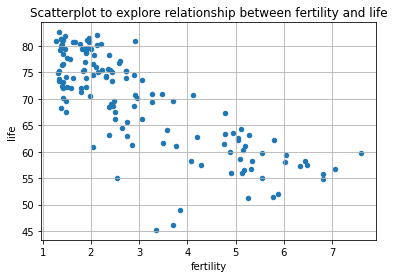

In [ ]:
regdfnew.toPandas().plot.scatter(x='fertility',y='life')
plt.title('Scatterplot to explore relationship between fertility and life')
plt.grid()
plt.show()

In [ ]:
regdfnew.createOrReplaceTempView("region_info_tbl")

In [ ]:
spark.sql("""SELECT fertility, life FROM region_info_tbl WHERE fertility > 1.0 AND life > 70""").show(10)

+---------+----+
|fertility|life|
+---------+----+
|     2.73|75.3|
|     2.24|75.5|
|      1.4|72.5|
|     1.96|81.5|
|     1.41|80.4|
|     1.99|70.6|
|     1.89|72.2|
|     1.83|75.3|
|     1.42|70.1|
|     1.82|79.4|
+---------+----+
only showing top 10 rows



In [ ]:
assembler = VectorAssembler(inputCols = ['fertility'], outputCol = 'feature')
regdf1 = assembler.transform(regdfnew)
regdf1 = regdf1.select(['feature', 'life'])
regdf1.show(5)

+-------+----+
|feature|life|
+-------+----+
| [2.73]|75.3|
| [6.43]|58.3|
| [2.24]|75.5|
|  [1.4]|72.5|
| [1.96]|81.5|
+-------+----+
only showing top 5 rows



In [ ]:
# Fitting linear regression, regparam = 0, elasticNetParam = 0
from pyspark.ml.regression import LinearRegression
linreg = LinearRegression(regParam=0.0, elasticNetParam=0.0,featuresCol="feature", labelCol="life")
linregmodel = linreg.fit(regdf1)
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(linregmodel.coefficients))
print("Intercept: %s" % str(linregmodel.intercept))

# Summarize the model over the training set and print out some metrics
Summary = linregmodel.summary
print("Total iterations: %d" % Summary.totalIterations)
print("RMSE: %f" % Summary.rootMeanSquaredError)
print("r2: %f" % Summary.r2)

Coefficients: [-4.443878989782824]
Intercept: 82.9572136174258
Total iterations: 1
RMSE: 5.608600
r2: 0.619244


In [ ]:
assembler = VectorAssembler(inputCols = ['population','fertility','HIV','CO2','BMI_male','GDP','BMI_female','child_mortality'], 
                            outputCol = 'features')
regdf2 = assembler.transform(regdfnew)
regdf2 = regdf2.select(['features', 'life'])
regdf2.show(5)

+--------------------+----+
|            features|life|
+--------------------+----+
|[3.4811059E7,2.73...|75.3|
|[1.9842251E7,6.43...|58.3|
|[4.038186E7,2.24,...|75.5|
|[2975029.0,1.4,0....|72.5|
|[2.1370348E7,1.96...|81.5|
+--------------------+----+
only showing top 5 rows



In [ ]:
# Fitting lasso regression model regparam > 0, elasticNetParam = 1
lasso = LinearRegression(regParam=0.1, elasticNetParam=1,featuresCol="features", labelCol="life")
lassomodel = lasso.fit(regdf2)
# Print the coefficients and intercept for Lasso regression
print("Coefficients: %s" % str(lassomodel.coefficients))
print("Intercept: %s" % str(lassomodel.intercept))

# Evaluation of model
Summary = lassomodel.summary
print("Total iterations: %d" % Summary.totalIterations)
print("RMSE: %f" % Summary.rootMeanSquaredError)
print("r2: %f" % Summary.r2)

Coefficients: [-7.696206389167578e-10,-0.3653839995639762,-0.580753745581431,-0.11144185783203375,0.2964296243753301,0.00011286974413286391,-0.24667603802178747,-0.09485575687920328]
Intercept: 98.69276254731761
Total iterations: 49
RMSE: 2.928597
r2: 0.896186
